# Instalación Librerias

In [ ]:
%pip install numpy

In [ ]:
%pip install matplotlib
%pip install pandas

In [ ]:
%pip install scipy

In [ ]:
%pip install seaborn

In [ ]:
%pip install PyWavelets

In [ ]:
%pip install statsmodels

In [ ]:
%pip install scikit-image

# Imporatción libreria

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as signal
from scipy.signal import butter, filtfilt, firwin, lfilter, welch
from random import randrange
from scipy import fft
import os
import seaborn as sns
import scipy.stats as stats
import pywt
from statsmodels.nonparametric.smoothers_lowess import lowess
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.util import random_noise

# Consulta Punto 1

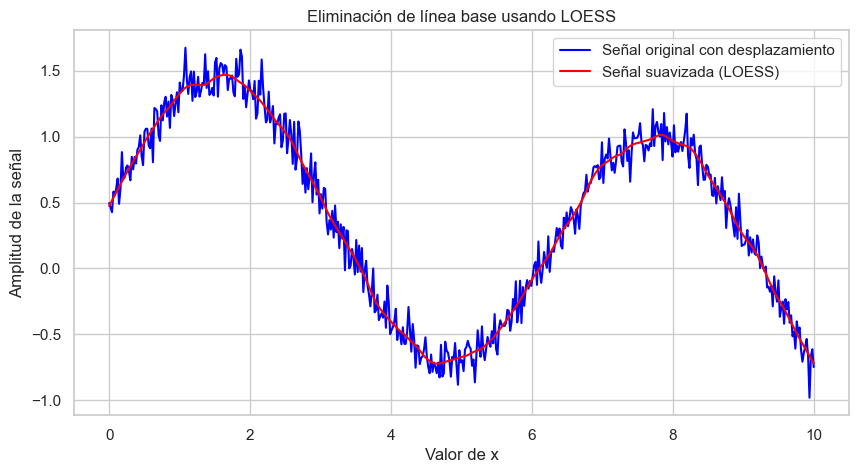

In [139]:
# Simulación de señal con desplazamiento de línea base
x = np.linspace(0, 10, 500)
y = np.sin(x) + 0.5 * np.cos(0.2 * x) + 0.1 * np.random.normal(size=500)

# Aplicación de LOESS
y_smooth = lowess(y, x, frac=0.05, it=3)[:, 1]

# Visualización de resultados
plt.figure(figsize=(10, 5))
plt.plot(x, y, label='Señal original con desplazamiento', color='blue')
plt.plot(x, y_smooth, label='Señal suavizada (LOESS)', color='red')
plt.title("Eliminación de línea base usando LOESS")
plt.legend()
plt.xlabel('Valor de x')
plt.ylabel('Amplitud de la señal')
plt.show()

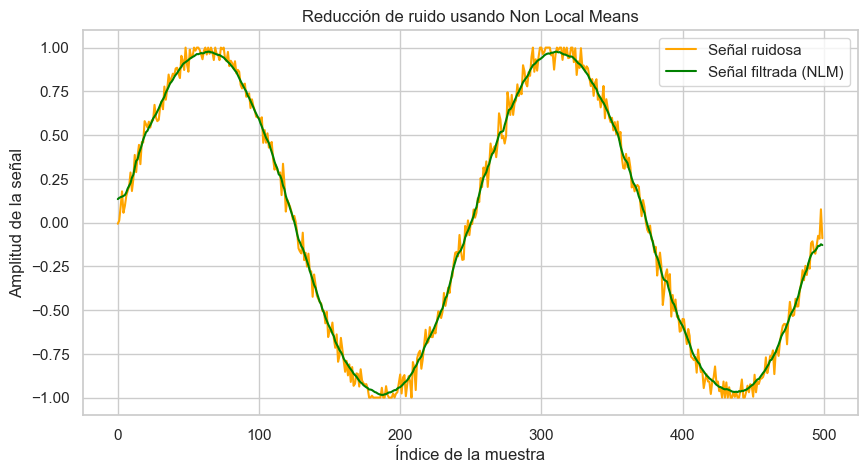

In [140]:
# Creación de señal ruidosa
np.random.seed(42)
signal = np.sin(np.linspace(0, 4 * np.pi, 500))
noisy_signal = random_noise(signal, var=0.05**2)

# Estimación de la desviación estándar del ruido
sigma_est = np.sqrt(estimate_sigma(noisy_signal))

# Convertir la señal 1D en 2D (una fila)
noisy_signal_2d = noisy_signal.reshape(1, -1)

# Filtrado con Non Local Means
denoised_signal_2d = denoise_nl_means(noisy_signal_2d, h=1.15 * sigma_est, fast_mode=True, patch_size=5, patch_distance=11)

# Convertir la señal filtrada de nuevo a 1D
denoised_signal = denoised_signal_2d.flatten()

# Visualización de resultados
plt.figure(figsize=(10, 5))
plt.plot(noisy_signal, label='Señal ruidosa', color='orange')
plt.plot(denoised_signal, label='Señal filtrada (NLM)', color='green')
plt.title("Reducción de ruido usando Non Local Means")
plt.legend()
plt.xlabel('Índice de la muestra')
plt.ylabel('Amplitud de la señal')
plt.show()

# Carga datos de prueba (10 señales aleatorias)

In [90]:
file_path = 'Diagnostics.csv'
diagnos_data = pd.read_csv(file_path)
diagnos_data.head()

,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
2,MUSE_20180111_165520_97000,SA,NONE,20,FEMALE,67,67,82,382,403,88,20,11,224,265,415
3,MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
4,MUSE_20180112_122850_57000,AF,STDD STTC,73,FEMALE,162,162,114,252,413,68,-40,26,228,285,354


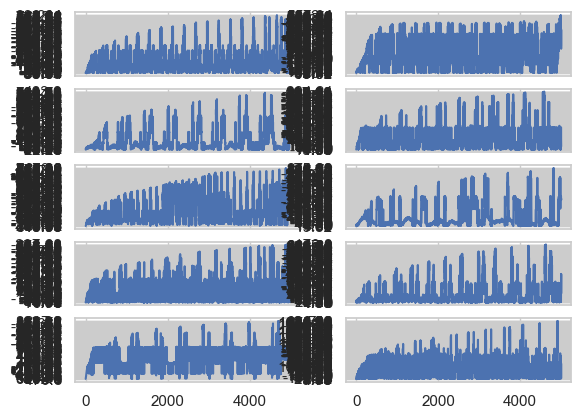

In [91]:
All_pacients = diagnos_data['FileName']
List_pacients=All_pacients.tolist()
folder_dir = 'ECGData/'
random_signals=[]
for i in range(0,10):
    file_path = folder_dir+List_pacients[randrange(len(List_pacients))]+'.csv'
    ecg_data = pd.read_csv(file_path,names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
    senal = ecg_data['II'].values
    random_signals.append(senal)

for i in range(len(random_signals)):
  random_signals[i]=random_signals[i][1:]

for i in range(len(random_signals)):
  plt.subplot(5,2,i+1)
  plt.plot(random_signals[i])
plt.show()
    

In [92]:
print(random_signals[0])

['-39.04' '-53.68' '-53.68' ... '43.92' '63.44' '68.32']


# Pruebas filtro Wavelet

## db6 level=8

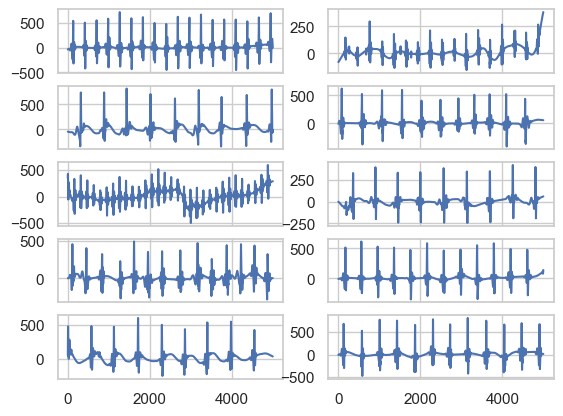

In [93]:
def wnoisest(coeff):
    stdc = np.zeros((len(coeff),1));
    for i in range(0,len(coeff)):
        stdc[i] = (np.median(np.absolute(coeff[i])))/0.6745;
    return stdc;

def threshold(coeff):
    Num_samples = 0;
    for i in range(0,len(coeff)):
        Num_samples = Num_samples + coeff[i].shape[0];
    
    thr = np.sqrt(2*(np.log(Num_samples)))
    return thr

def wthresh(coeff):
    y   = list()
    s = wnoisest(coeff)
    thr = threshold(coeff)
    for i in range(0,len(coeff)):
        y.append(np.multiply(coeff[i],np.abs(coeff[i])>(thr*s[i])))
    return thr,s,y


signals_wavelet = list()
for i in range(len(random_signals)):
    data_wavelet = pywt.wavedec( random_signals[i], 'db6', level=8 )
    details = data_wavelet[1:]
    thr, s, details_t = wthresh(details)
    coeff = list()
    coeff.append(data_wavelet[0])

    for i in range(len(details_t)):
        coeff.append(details_t[i])

    x_rec = pywt.waverec( coeff, 'db6');
    x_rec = x_rec[0:random_signals[i].shape[0]];
    signals_wavelet.append(x_rec)


for i in range(len(signals_wavelet)):
  plt.subplot(5,2,i+1)
  plt.plot(signals_wavelet[i])
plt.show()

## Sym4 Level=3

Se utiliza esta configuración para el filtro wavelet basado en lo obtenido por Fars Samann y Thomas Schanze en: An efficient ECG Denoising method using Discrete Wavelet with Savitzky-Golay filter. Recuperado de: https://www.degruyter.com/document/doi/10.1515/cdbme-2019-0097/html?srsltid=AfmBOopF74G7Z7d2__qt9qt7weH2eePBoWy0fJJivG2e4wo1kpCA9U3y 

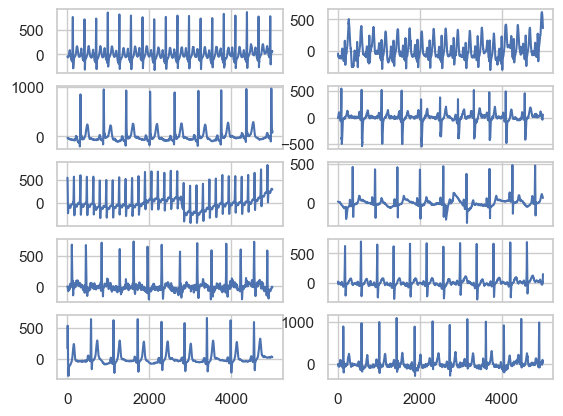

In [94]:
def wnoisest(coeff):
    stdc = np.zeros((len(coeff),1));
    for i in range(0,len(coeff)):
        stdc[i] = (np.median(np.absolute(coeff[i])))/0.6745;
    return stdc;

def threshold(coeff):
    Num_samples = 0;
    for i in range(0,len(coeff)):
        Num_samples = Num_samples + coeff[i].shape[0];
    
    thr = np.sqrt(2*(np.log(Num_samples)))
    return thr

def wthresh(coeff):
    y   = list()
    s = wnoisest(coeff)
    thr = threshold(coeff)
    for i in range(0,len(coeff)):
        y.append(np.multiply(coeff[i],np.abs(coeff[i])>(thr*s[i])))
    return thr,s,y


signals_wavelet = list()
for i in range(len(random_signals)):
    data_wavelet = pywt.wavedec( random_signals[i], 'sym4', level=3 )
    details = data_wavelet[1:]
    thr, s, details_t = wthresh(details)
    coeff = list()
    coeff.append(data_wavelet[0])

    for i in range(len(details_t)):
        coeff.append(details_t[i])

    x_rec = pywt.waverec( coeff, 'sym4');
    x_rec = x_rec[0:senal.shape[0]];
    signals_wavelet.append(x_rec)


for i in range(len(signals_wavelet)):
  plt.subplot(5,2,i+1)
  plt.plot(signals_wavelet[i])
plt.show()

# Flujo de Filtrado 1

## Filtro Pasa-Altas IIR a 0.5 Hz

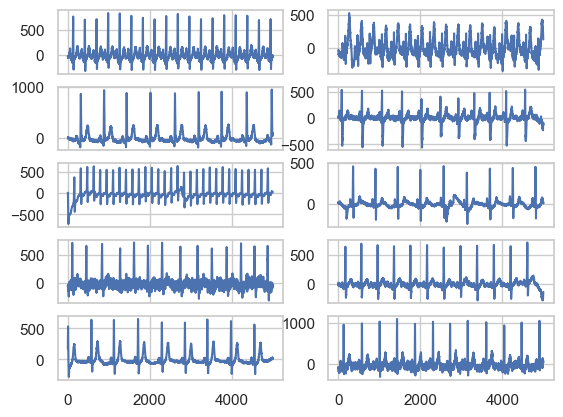

In [100]:
# Parámetros del filtro
fs = 500  # Frecuencia de muestreo en Hz
cutoff = 0.5  # Frecuencia de corte en Hz
orden = 2  # Orden del filtro

# Función para diseñar el filtro IIR pasa-altas
def highpass_filter(data, cutoff, fs, orden):
    nyquist = 0.5 * fs  # Frecuencia de Nyquist
    normal_cutoff = cutoff / nyquist
    b, a = butter(orden, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)  # Aplicación del filtro en ambos sentidos para eliminar el desfase
    return y

# Aplicación del filtro a la señal
signals_filtered_iir = list()
for i in range(len(random_signals)):
    # Convertir la señal a tipo float
    signal_numeric = random_signals[i].astype(float)
    signals_filtered_iir.append(highpass_filter(signal_numeric, cutoff, fs, orden))

for i in range(len(signals_filtered_iir)):
  plt.subplot(5,2,i+1)
  plt.plot(signals_filtered_iir[i])
plt.show()

## Filtro Wavelet sym4 level=3

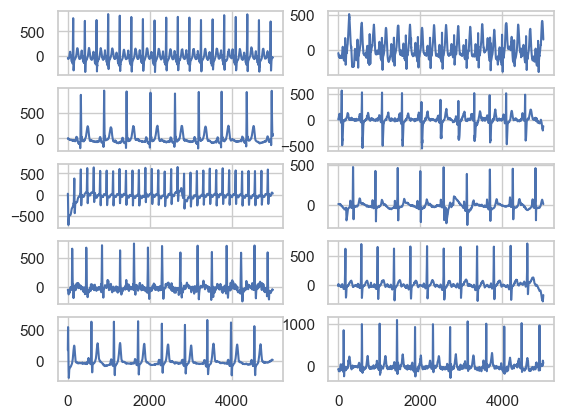

In [101]:
signals_wavelet = list()
for i in range(len(signals_filtered_iir)):
    data_wavelet = pywt.wavedec( signals_filtered_iir[i], 'sym4', level=3 )
    details = data_wavelet[1:]
    thr, s, details_t = wthresh(details)
    coeff = list()
    coeff.append(data_wavelet[0])

    for i in range(len(details_t)):
        coeff.append(details_t[i])

    x_rec = pywt.waverec( coeff, 'sym4');
    x_rec = x_rec[0:signals_filtered_iir[i].shape[0]];
    signals_wavelet.append(x_rec)


for i in range(len(signals_wavelet)):
  plt.subplot(5,2,i+1)
  plt.plot(signals_wavelet[i])
plt.show()

## Filtro Pasa-Bajas FIIR a 50 Hz

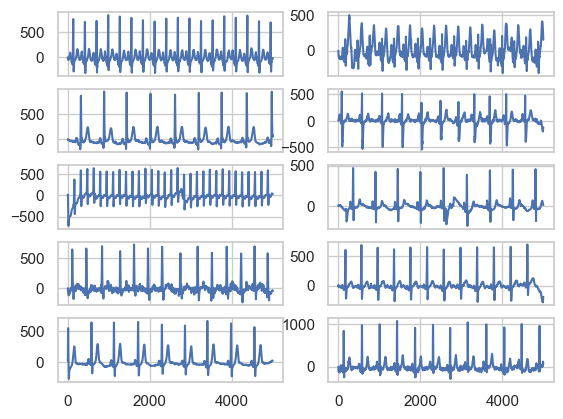

In [102]:
# Parámetros del filtro FIR
fs = 500  # Frecuencia de muestreo en Hz
cutoff = 50  # Frecuencia de corte en Hz
order = 200  # Orden del filtro

# Diseño del filtro FIR pasa-bajas
def lowpass_filter(data, cutoff, fs, order, window='hamming'):
    nyquist = 0.5 * fs  # Frecuencia de Nyquist
    normal_cutoff = cutoff / nyquist  # Frecuencia de corte normalizada
    taps = firwin(order + 1, normal_cutoff, window=window)  # Coeficientes del filtro
    y = lfilter(taps, 1.0, data)  # Filtrado de la señal
    return y

# Aplicación del filtro a la señal
signals_filtered_fiir = list()
for i in range(len(signals_wavelet)):
    signals_filtered_fiir.append(lowpass_filter(signals_wavelet[i], cutoff, fs, orden))

for i in range(len(signals_filtered_fiir)):
  plt.subplot(5,2,i+1)
  plt.plot(signals_filtered_fiir[i])
plt.show()



# Flujo de Filtrado 2

## Detrend

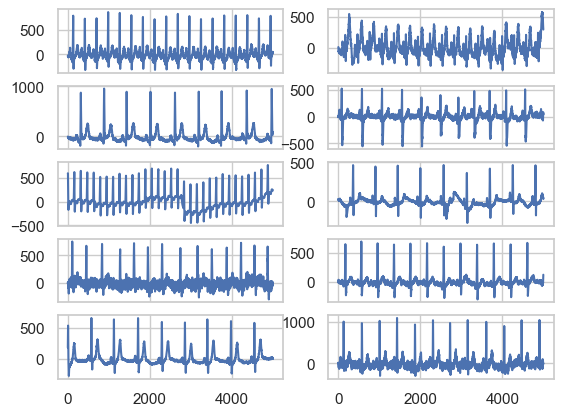

In [95]:
# Aplicación del detrend a la señal
signals_detrended = list()
for i in range(len(random_signals)):
    detrended_signal = signal.detrend(random_signals[i])
    signals_detrended.append(detrended_signal)

for i in range(len(signals_detrended)):
  plt.subplot(5,2,i+1)
  plt.plot(signals_detrended[i])
plt.show()

## Filtro Wavelet sym4 level=3

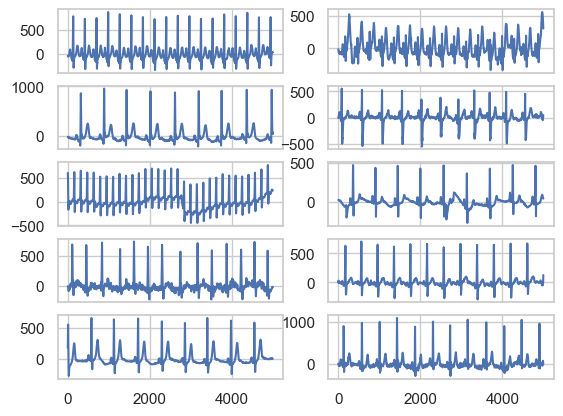

In [96]:
signals_wavelet = list()
for i in range(len(signals_detrended)):
    data_wavelet = pywt.wavedec( signals_detrended[i], 'sym4', level=3 )
    details = data_wavelet[1:]
    thr, s, details_t = wthresh(details)
    coeff = list()
    coeff.append(data_wavelet[0])

    for i in range(len(details_t)):
        coeff.append(details_t[i])

    x_rec = pywt.waverec( coeff, 'sym4');
    x_rec = x_rec[0:signals_detrended[i].shape[0]];
    signals_wavelet.append(x_rec)


for i in range(len(signals_wavelet)):
  plt.subplot(5,2,i+1)
  plt.plot(signals_wavelet[i])
plt.show()

## Filtro Pasa-Bajas FIIR a 50Hz

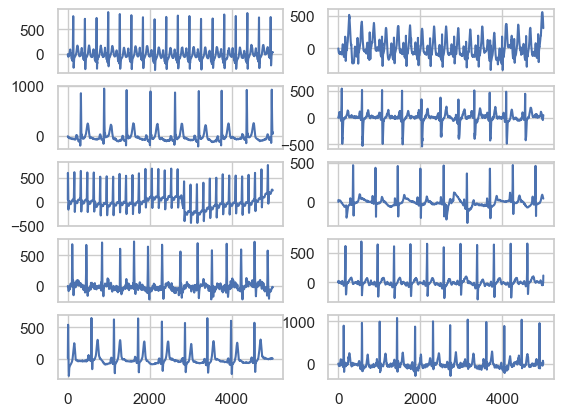

In [97]:
# Parámetros del filtro FIR
fs = 500  # Frecuencia de muestreo en Hz
cutoff = 50  # Frecuencia de corte en Hz
order = 200  # Orden del filtro

# Diseño del filtro FIR pasa-bajas
def lowpass_filter(data, cutoff, fs, order, window='hamming'):
    nyquist = 0.5 * fs  # Frecuencia de Nyquist
    normal_cutoff = cutoff / nyquist  # Frecuencia de corte normalizada
    taps = firwin(order + 1, normal_cutoff, window=window)  # Coeficientes del filtro
    y = lfilter(taps, 1.0, data)  # Filtrado de la señal
    return y

# Aplicación del filtro a la señal
signals_filtered_fiir = list()
for i in range(len(signals_wavelet)):
    signals_filtered_fiir.append(lowpass_filter(signals_wavelet[i], cutoff, fs, orden))

for i in range(len(signals_filtered_fiir)):
  plt.subplot(5,2,i+1)
  plt.plot(signals_filtered_fiir[i])
plt.show()

# Flujo de Filtrado 3

## Filtro Pasa-Altas IIR a 0.5 Hz

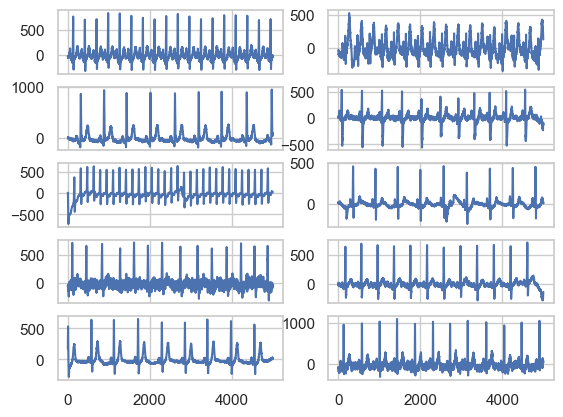

In [103]:
# Parámetros del filtro
fs = 500  # Frecuencia de muestreo en Hz
cutoff = 0.5  # Frecuencia de corte en Hz
orden = 2  # Orden del filtro

# Función para diseñar el filtro IIR pasa-altas
def highpass_filter(data, cutoff, fs, orden):
    nyquist = 0.5 * fs  # Frecuencia de Nyquist
    normal_cutoff = cutoff / nyquist
    b, a = butter(orden, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)  # Aplicación del filtro en ambos sentidos para eliminar el desfase
    return y

# Aplicación del filtro a la señal
signals_filtered_iir = list()
for i in range(len(random_signals)):
    # Convertir la señal a tipo float
    signal_numeric = random_signals[i].astype(float)
    signals_filtered_iir.append(highpass_filter(signal_numeric, cutoff, fs, orden))

for i in range(len(signals_filtered_iir)):
  plt.subplot(5,2,i+1)
  plt.plot(signals_filtered_iir[i])
plt.show()

## Filtro Pasa-Bajas FIIR a 50 Hz

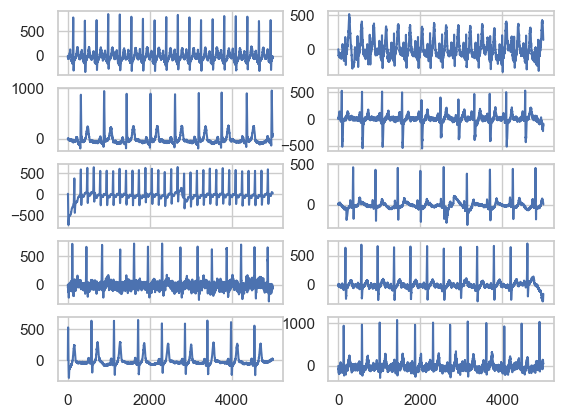

In [104]:
# Parámetros del filtro FIR
fs = 500  # Frecuencia de muestreo en Hz
cutoff = 50  # Frecuencia de corte en Hz
order = 200  # Orden del filtro

# Diseño del filtro FIR pasa-bajas
def lowpass_filter(data, cutoff, fs, order, window='hamming'):
    nyquist = 0.5 * fs  # Frecuencia de Nyquist
    normal_cutoff = cutoff / nyquist  # Frecuencia de corte normalizada
    taps = firwin(order + 1, normal_cutoff, window=window)  # Coeficientes del filtro
    y = lfilter(taps, 1.0, data)  # Filtrado de la señal
    return y

# Aplicación del filtro a la señal
signals_filtered_fiir = list()
for i in range(len(signals_filtered_iir)):
    signals_filtered_fiir.append(lowpass_filter(signals_filtered_iir[i], cutoff, fs, orden))

for i in range(len(signals_filtered_fiir)):
  plt.subplot(5,2,i+1)
  plt.plot(signals_filtered_fiir[i])
plt.show()

# Compresión y Análisis espectral (Welch)

## Compresión

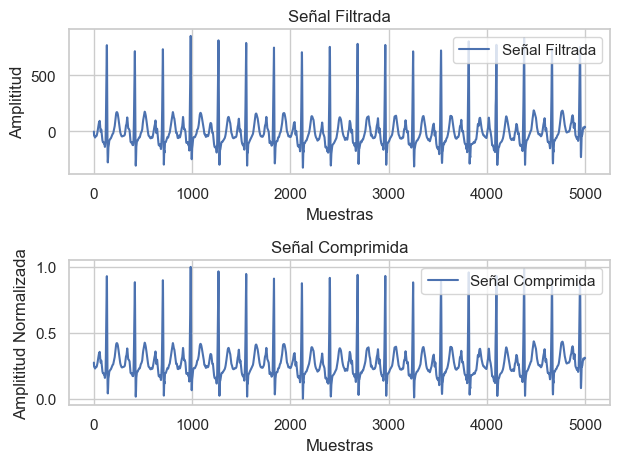

In [98]:
# función para comprimir la señal
def compress_signal(senal):
    x_min = np.min(senal)
    x_max = np.max(senal)
    compressed_signal = (senal - x_min) / (x_max - x_min)
    return compressed_signal

# Función comprimida
compressed_signal = compress_signal(signals_filtered_fiir[0])

# Plot señal filtrada
plt.subplot(2, 1, 1)
plt.plot(signals_filtered_fiir[0], label="Señal Filtrada")
plt.title("Señal Filtrada")
plt.xlabel("Muestras")
plt.ylabel("Amplititud")
plt.grid(True)
plt.legend()

# Plot señal filtrada y comprimida
plt.subplot(2, 1, 2)
plt.plot(compressed_signal, label="Señal Comprimida")
plt.title("Señal Comprimida")
plt.xlabel("Muestras")
plt.ylabel("Amplititud Normalizada")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Welch

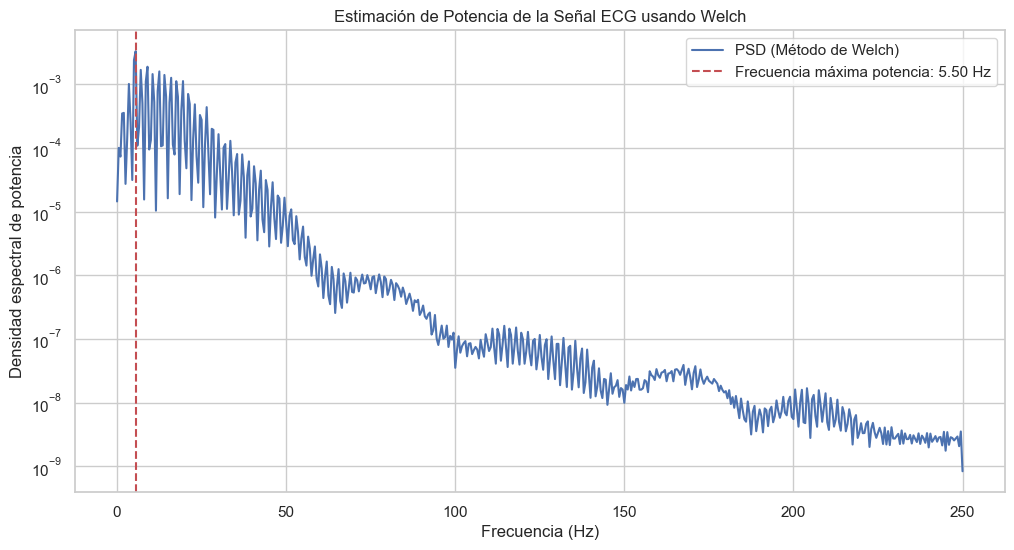

Frecuencia con máxima potencia: 5.50 Hz, Potencia: 0.0033


In [99]:
fs=500
window = 'hamming'
nperseg = int(2 * fs)  # Segmentos de 2 segundos
noverlap = nperseg // 2  # 50% de solapamiento

frequencies, psd = welch(compressed_signal, fs, window=window, nperseg=nperseg, noverlap=noverlap)

# Encontrar la frecuencia con la máxima potencia
max_power_frequency = frequencies[np.argmax(psd)]
max_power_value = np.max(psd)

# Mostrar resultados
plt.figure(figsize=(12, 6))
plt.semilogy(frequencies, psd, label="PSD (Método de Welch)")
plt.axvline(max_power_frequency, color='r', linestyle='--', label=f'Frecuencia máxima potencia: {max_power_frequency:.2f} Hz')
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Densidad espectral de potencia")
plt.title("Estimación de Potencia de la Señal ECG usando Welch")
plt.legend()
plt.show()

print(f"Frecuencia con máxima potencia: {max_power_frequency:.2f} Hz, Potencia: {max_power_value:.4f}")

# Carga Masiva de Datos y proceso iterativo AFIB

In [105]:
file_path = 'Diagnostics.csv'
diagnos_data = pd.read_csv(file_path)
diagnos_data.head()


,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
2,MUSE_20180111_165520_97000,SA,NONE,20,FEMALE,67,67,82,382,403,88,20,11,224,265,415
3,MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
4,MUSE_20180112_122850_57000,AF,STDD STTC,73,FEMALE,162,162,114,252,413,68,-40,26,228,285,354


In [106]:
AFIB_pacients = diagnos_data.loc[diagnos_data['Rhythm'] == 'AFIB', 'FileName']
print(len(AFIB_pacients.tolist()))

1780


Se procede con el flujo de filtrado 2, aunque el flujo 1 y 2 obtienen resultados similares, al evitar el uso de un filtro IIR en el segundo flujo, estamos seguros de que la fase y respuesta frecuencial de la señal no se veran afectadas, más allá del denoising que se busca

In [107]:
folder_dir = 'ECGData/'
registros=[]
for file in os.listdir(folder_dir):
    if file[:-4] in AFIB_pacients.tolist():
        registro=[]
        registro.append(file[:-4])
        registro.append('AFIB')
        dir = folder_dir + file
        ecg_data = pd.read_csv(dir,names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
        senal = ecg_data['II'].values
        fs = 500
        senal=senal[1:]
        detrended_signal = signal.detrend(senal)
        data_wavelet = pywt.wavedec( detrended_signal, 'sym4', level=3 )
        details = data_wavelet[1:]
        thr, s, details_t = wthresh(details)
        coeff = list()
        coeff.append(data_wavelet[0])
        for i in range(len(details_t)):
            coeff.append(details_t[i])
        x_rec = pywt.waverec( coeff, 'sym4');
        x_rec = x_rec[0:signals_detrended[i].shape[0]]
        cutoff = 50  # Frecuencia de corte en Hz
        order = 200  # Orden del filtro
        # Aplicación del filtro a la señal
        signal_filtered_fiir = lowpass_filter(x_rec, cutoff, fs, orden)
        compressed_signal = compress_signal(signal_filtered_fiir)
        window = 'hamming'
        nperseg = int(2 * fs)  # Segmentos de 2 segundos
        noverlap = nperseg // 2  # 50% de solapamiento
        frequencies, psd = welch(compressed_signal, fs, window=window, nperseg=nperseg, noverlap=noverlap)
        # Encontrar la frecuencia con la máxima potencia
        max_power_freq = frequencies[np.argmax(psd)]
        registro.append(max_power_freq)
        registros.append(registro)

print(len(registros))



1780


In [108]:
columnas = ['Registro', 'Estado', 'fMP']
df_AFIB = pd.DataFrame(registros,columns=columnas)
df_AFIB.sort_values(by=['Registro'])
#Almacenamos la tabla de análisis como CSV en la carpeta del proyecto
df_AFIB.to_csv('Resultados/df_AFIB.csv', index=False)

In [109]:
file_path = 'Resultados/df_AFIB.csv'
resultado_AFIB = pd.read_csv(file_path)
resultado_AFIB.head()

,Registro,Estado,fMP
0,MUSE_20180112_074345_57000,AFIB,4.0
1,MUSE_20180113_182054_43000,AFIB,3.0
2,MUSE_20180116_181851_46000,AFIB,3.5
3,MUSE_20180116_125104_99000,AFIB,8.0
4,MUSE_20180118_135259_10000,AFIB,3.5


# Proceso iterativo SB

In [110]:
SB_pacients = diagnos_data.loc[diagnos_data['Rhythm'] == 'SB', 'FileName']
print(len(SB_pacients.tolist()))

3889


In [111]:
folder_dir = 'ECGData/'
registros=[]
for file in os.listdir(folder_dir):
    if file[:-4] in SB_pacients.tolist():
        registro=[]
        registro.append(file[:-4])
        registro.append('SB')
        dir = folder_dir + file
        ecg_data = pd.read_csv(dir,names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
        senal = ecg_data['II'].values
        fs = 500
        senal=senal[1:]
        detrended_signal = signal.detrend(senal)
        data_wavelet = pywt.wavedec( detrended_signal, 'sym4', level=3 )
        details = data_wavelet[1:]
        thr, s, details_t = wthresh(details)
        coeff = list()
        coeff.append(data_wavelet[0])
        for i in range(len(details_t)):
            coeff.append(details_t[i])
        x_rec = pywt.waverec( coeff, 'sym4');
        x_rec = x_rec[0:signals_detrended[i].shape[0]]
        cutoff = 50  # Frecuencia de corte en Hz
        order = 100  # Orden del filtro
        # Aplicación del filtro a la señal
        signal_filtered_fiir = lowpass_filter(x_rec, cutoff, fs, orden)
        compressed_signal = compress_signal(signal_filtered_fiir)
        window = 'hamming'
        nperseg = int(2 * fs)  # Segmentos de 2 segundos
        noverlap = nperseg // 2  # 50% de solapamiento
        frequencies, psd = welch(compressed_signal, fs, window=window, nperseg=nperseg, noverlap=noverlap)
        # Encontrar la frecuencia con la máxima potencia
        max_power_freq = frequencies[np.argmax(psd)]
        registro.append(max_power_freq)
        registros.append(registro)

print(len(registros))

3889


In [112]:
columnas = ['Registro', 'Estado', 'fMP']
df_SB = pd.DataFrame(registros,columns=columnas)
df_SB.sort_values(by=['Registro'])
#Almacenamos la tabla de análisis como CSV en la carpeta del proyecto
df_SB.to_csv('Resultados/df_SB.csv', index=False)

In [113]:
file_path = 'Resultados/df_SB.csv'
resultado_SB = pd.read_csv(file_path)
resultado_SB.head()

,Registro,Estado,fMP
0,MUSE_20180112_140243_67000,SB,1.0
1,MUSE_20180119_171353_86000,SB,1.0
2,MUSE_20180115_133859_76000,SB,4.0
3,MUSE_20180113_180006_45000,SB,0.5
4,MUSE_20180112_072033_34000,SB,0.5


#  Creación Dataframe general

In [114]:
# Append de los 2 DFs
result_append = pd.concat([df_AFIB, df_SB], ignore_index=True)
result_append.head()
result_append.sort_values(by=['Registro'])
#Almacenamos la tabla de análisis como CSV en la carpeta del proyecto
result_append.to_csv('Resultados/tabla_general_noise.csv', index=False)

# Análisis estadistica descriptiva Resultados

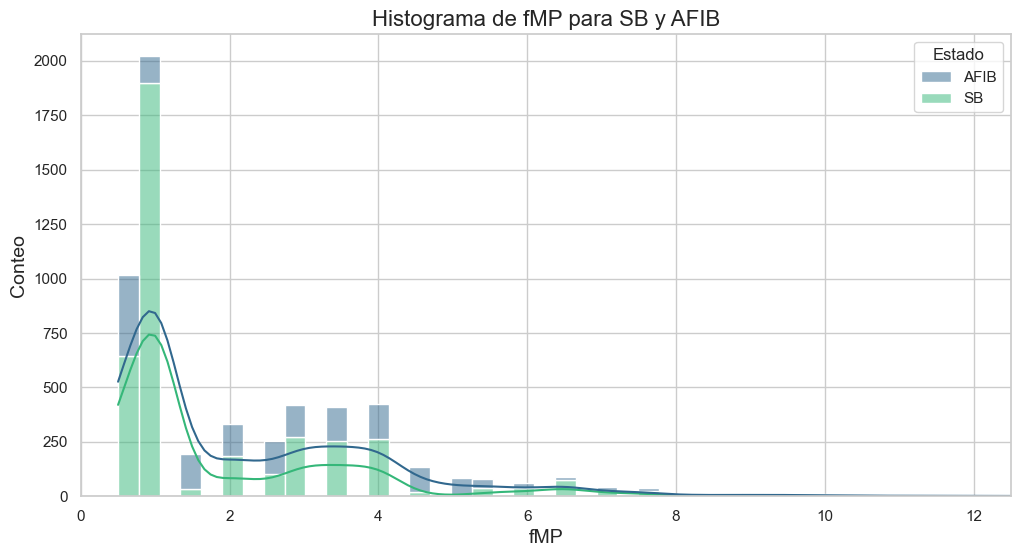

In [115]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Plot the histogram
sns.histplot(data=result_append, x='fMP', hue='Estado', multiple='stack', kde=True, palette='viridis')

# Add titles and labels
plt.title('Histograma de fMP para SB y AFIB', fontsize=16)
plt.xlabel('fMP', fontsize=14)
plt.ylabel('Conteo', fontsize=14)

# Show the plot
plt.xlim([0,12.5])
plt.show()

/var/folders/cz/nwy4xdnj77j0w2l0v6vdd11m0000gn/T/ipykernel_40402/2092615862.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=result_append, x='Estado', y='fMP', palette='viridis')


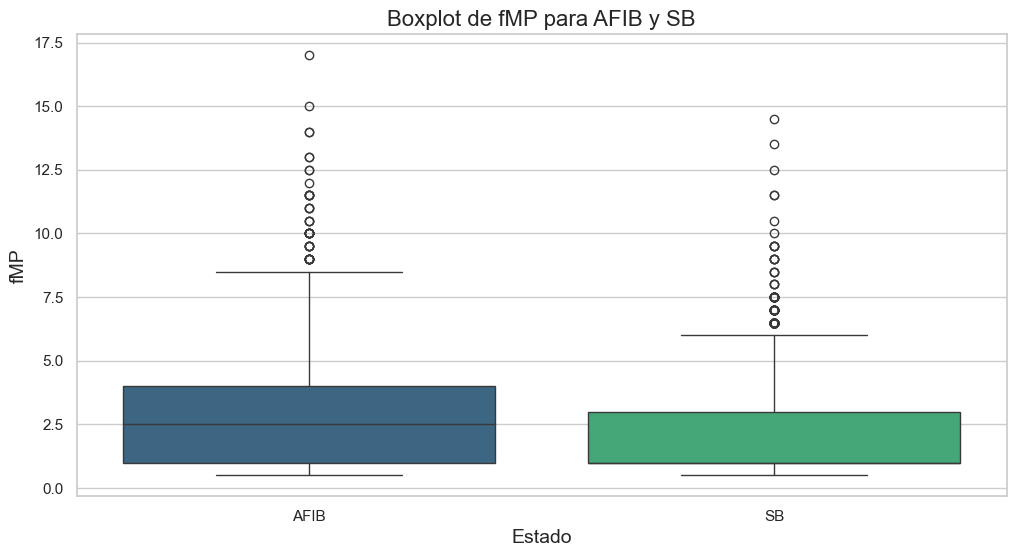

In [116]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Create the boxplot
sns.boxplot(data=result_append, x='Estado', y='fMP', palette='viridis')

# Add titles and labels
plt.title('Boxplot de fMP para AFIB y SB', fontsize=16)
plt.xlabel('Estado', fontsize=14)
plt.ylabel('fMP', fontsize=14)

# Show the plot
plt.show()

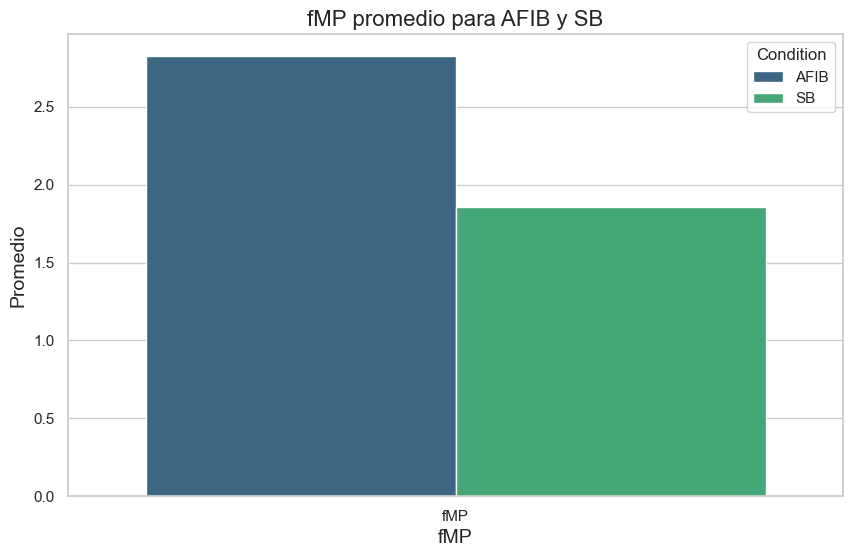

In [117]:
# Calculate mean fMP for AFIB and SB
mean_fMP_AFIB = df_AFIB['fMP'].mean()
mean_fMP_SB = df_SB['fMP'].mean()

# Create a DataFrame for plotting
mean_values = pd.DataFrame({
    'Metric': ['fMP'],
    'AFIB': [mean_fMP_AFIB],
    'SB': [mean_fMP_SB]
})

# Plot the mean fMP for AFIB and SB
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='value', hue='variable', data=pd.melt(mean_values, id_vars=['Metric']), palette='viridis')
plt.title('fMP promedio para AFIB y SB', fontsize=16)
plt.xlabel('fMP', fontsize=14)
plt.ylabel('Promedio', fontsize=14)
plt.legend(title='Condition')
plt.show()

# Análisis de diferencia estadistica Resultados

In [118]:
df = result_append
# Separar los datos en dos grupos: SB y AFIB
df_SB = df[df['Estado'] == 'SB']
df_AFIB = df[df['Estado'] == 'AFIB']

# Función para evaluar la normalidad
def evaluar_normalidad(data, variable):
    if data.isnull().any():  # Verificar si hay valores NaN
        print(f"Advertencia: Hay valores NaN en los datos de {variable}.")
        data = data.dropna()  # Opcional: eliminar NaNs

    # Realizar la prueba de Shapiro-Wilk
    stat, p_value = stats.shapiro(data)
    print(f"Resultados de la Prueba de Shapiro-Wilk para {variable}:")
    print(f"Estadístico: {stat}, p-valor: {p_value}")

    if p_value > 0.05:
        print(f"Los datos de {variable} parecen seguir una distribución normal.\n")
        return True  # Normal
    else:
        print(f"Los datos de {variable} no siguen una distribución normal.\n")
        return False  # No normal

# Variables a analizar
variables = ['fMP']

# Evaluar la normalidad en SB y AFIB
for variable in variables:
    print(f"\nEvaluación de la normalidad para {variable}:")
    normal_SB = evaluar_normalidad(df_SB[variable], f"SB - {variable}")
    normal_AFIB = evaluar_normalidad(df_AFIB[variable], f"AFIB - {variable}")

    # Seleccionar la prueba estadística adecuada
    if normal_SB and normal_AFIB:
        # Prueba paramétrica (T-test)
        t_stat, p_value = stats.ttest_ind(df_SB[variable], df_AFIB[variable], equal_var=False)
        print(f"Prueba T para {variable}: t = {t_stat}, p-valor = {p_value}\n")
    else:
        # Prueba no paramétrica (Mann-Whitney U)
        u_stat, p_value = stats.mannwhitneyu(df_SB[variable], df_AFIB[variable], alternative='two-sided')
        print(f"Prueba Mann-Whitney U para {variable}: u = {u_stat}, p-valor = {p_value}\n")



Evaluación de la normalidad para fMP:
Resultados de la Prueba de Shapiro-Wilk para SB - fMP:
Estadístico: 0.7285176966722418, p-valor: 3.6988188038571728e-62
Los datos de SB - fMP no siguen una distribución normal.

Resultados de la Prueba de Shapiro-Wilk para AFIB - fMP:
Estadístico: 0.8684582552973183, p-valor: 2.8309472835367768e-36
Los datos de AFIB - fMP no siguen una distribución normal.

Prueba Mann-Whitney U para fMP: u = 2509722.0, p-valor = 1.6926143077720504e-65



In [119]:
# Separar los datos en dos grupos: SB y AFIB
grupo_SB = df[df['Estado'] == 'SB']
grupo_AFIB = df[df['Estado'] == 'AFIB']

# Estadística descriptiva para SB y AFIB
descriptiva_SB = grupo_SB[['fMP']].describe()
descriptiva_AFIB = grupo_AFIB[['fMP']].describe()

print("Estadística descriptiva para SB:")
print(descriptiva_SB)

print("\nEstadística descriptiva para AFIB:")
print(descriptiva_AFIB)

# Realizar pruebas estadísticas entre los grupos SB y AFIB
# 1. T-test para la frecuencia de máxima potencia (fMP)
t_test_fMP = stats.ttest_ind(grupo_SB['fMP'], grupo_AFIB['fMP'], equal_var=False)

# Resultados de las pruebas t
print("\nT-test para la frecuencia de máxima potencia (fMP):", t_test_fMP)

Estadística descriptiva para SB:
               fMP
count  3889.000000
mean      1.858061
std       1.658169
min       0.500000
25%       1.000000
50%       1.000000
75%       3.000000
max      14.500000

Estadística descriptiva para AFIB:
               fMP
count  1780.000000
mean      2.823596
std       2.161757
min       0.500000
25%       1.000000
50%       2.500000
75%       4.000000
max      17.000000

T-test para la frecuencia de máxima potencia (fMP): TtestResult(statistic=np.float64(-16.725913697130448), pvalue=np.float64(6.624149260687569e-60), df=np.float64(2774.107536878097))


# Análisis Proyecto 2 vs Proyecto 3

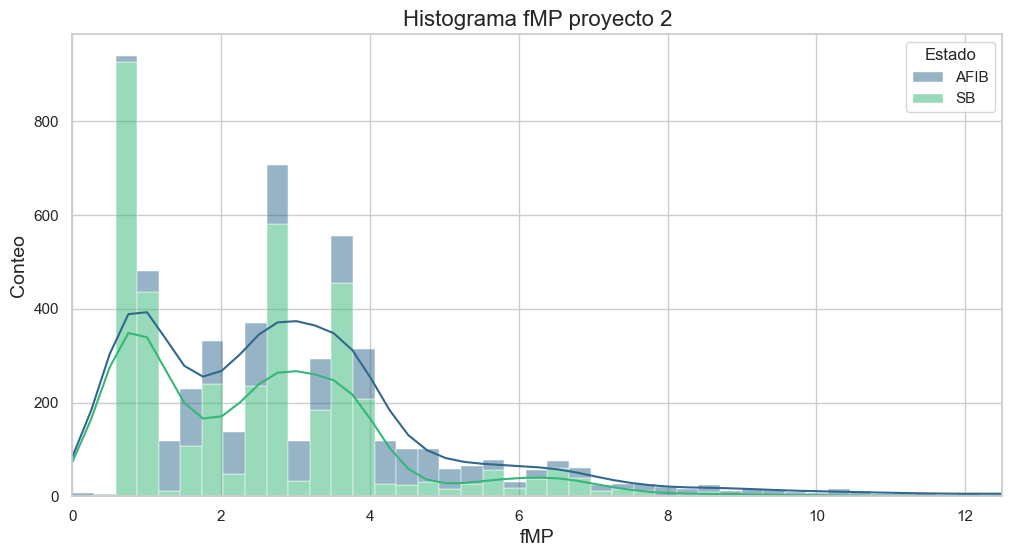

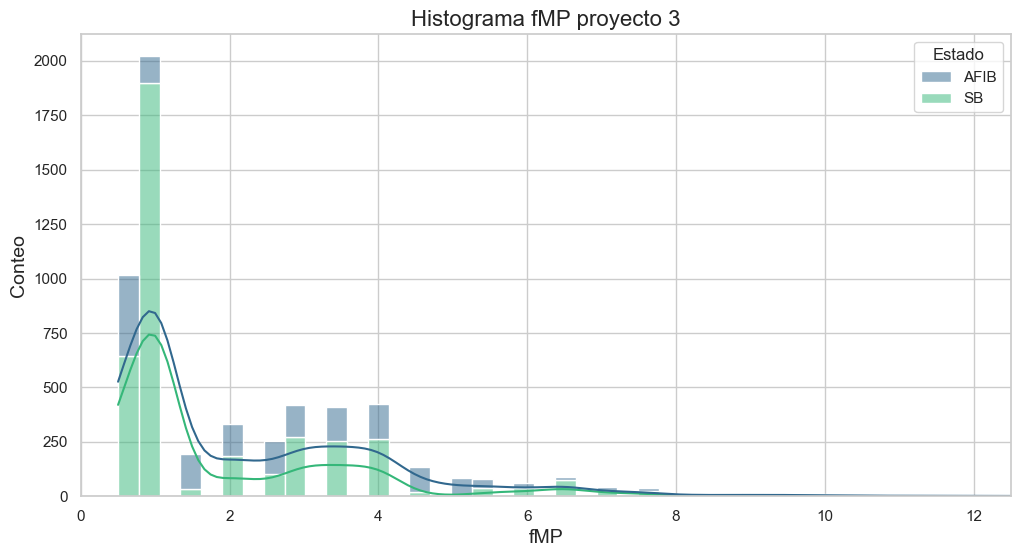

In [127]:
# Cargar la tabla_general desde la carpeta de resultados
file_path_general = 'Resultados/tabla_general.csv'
tabla_general = pd.read_csv(file_path_general)
tabla_general.head()

# Comparación gráfica de fMP entre tabla_general y tabla_general_noise
plt.figure(figsize=(12, 6))

# Histograma para tabla_general
sns.histplot(data=tabla_general, x='fMP', hue='Estado', multiple='stack', kde=True, palette='viridis')
plt.title('Histograma fMP proyecto 2', fontsize=16)
plt.xlabel('fMP', fontsize=14)
plt.ylabel('Conteo', fontsize=14)
plt.xlim([0,12.5])
plt.show()

plt.figure(figsize=(12, 6))
# Histograma para tabla_general_noise
sns.histplot(data=result_append, x='fMP', hue='Estado', multiple='stack', kde=True, palette='viridis')

# Añadir títulos y etiquetas
plt.title('Histograma fMP proyecto 3', fontsize=16)
plt.xlabel('fMP', fontsize=14)
plt.ylabel('Conteo', fontsize=14)
plt.xlim([0,12.5])
plt.show()


/var/folders/cz/nwy4xdnj77j0w2l0v6vdd11m0000gn/T/ipykernel_40402/2304184118.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=tabla_general, x='Estado', y='fMP', palette='viridis')


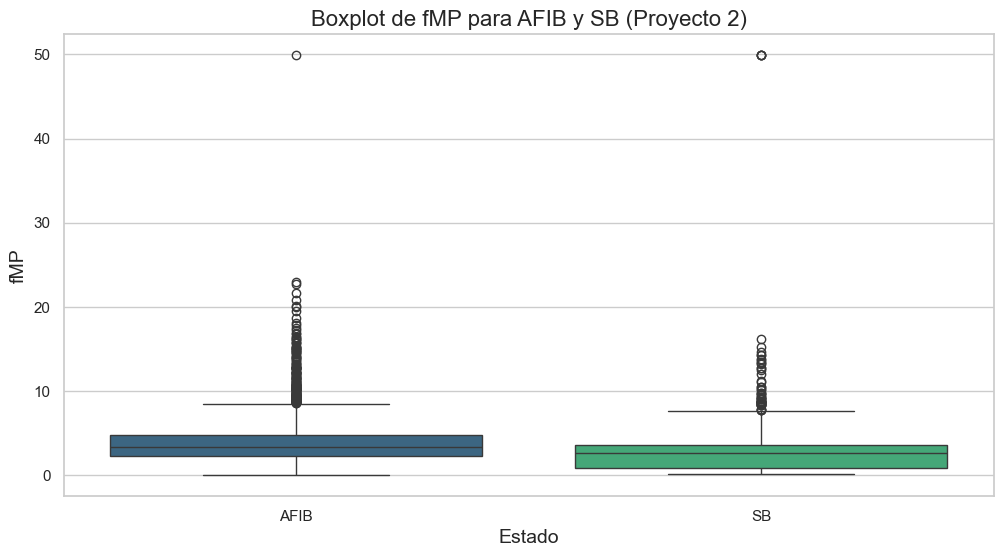

/var/folders/cz/nwy4xdnj77j0w2l0v6vdd11m0000gn/T/ipykernel_40402/2304184118.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=result_append, x='Estado', y='fMP', palette='viridis')


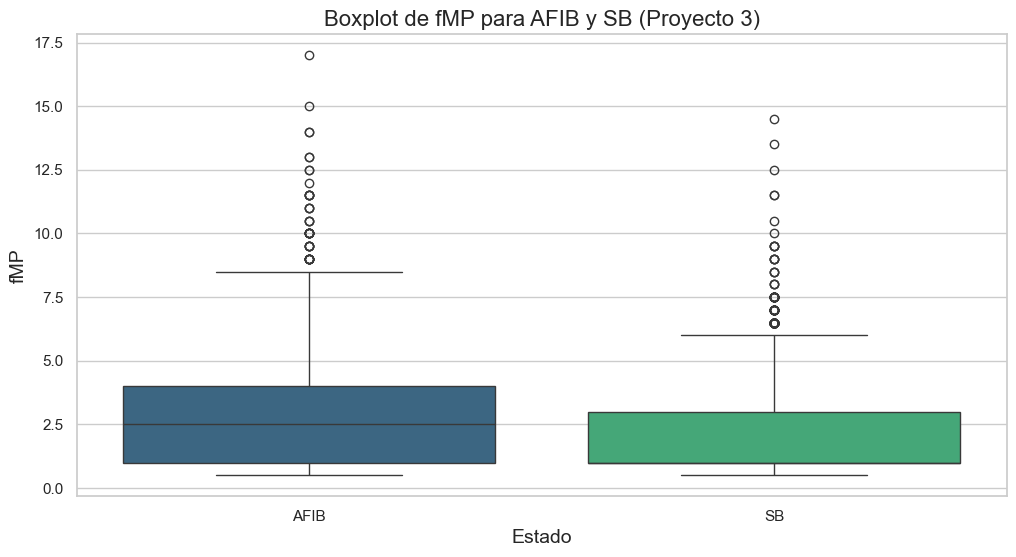

In [130]:
# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Create the boxplot
sns.boxplot(data=tabla_general, x='Estado', y='fMP', palette='viridis')

# Add titles and labels
plt.title('Boxplot de fMP para AFIB y SB (Proyecto 2)', fontsize=16)
plt.xlabel('Estado', fontsize=14)
plt.ylabel('fMP', fontsize=14)

# Show the plot
plt.show()

# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Create the boxplot
sns.boxplot(data=result_append, x='Estado', y='fMP', palette='viridis')

# Add titles and labels
plt.title('Boxplot de fMP para AFIB y SB (Proyecto 3)', fontsize=16)
plt.xlabel('Estado', fontsize=14)
plt.ylabel('fMP', fontsize=14)

# Show the plot
plt.show()



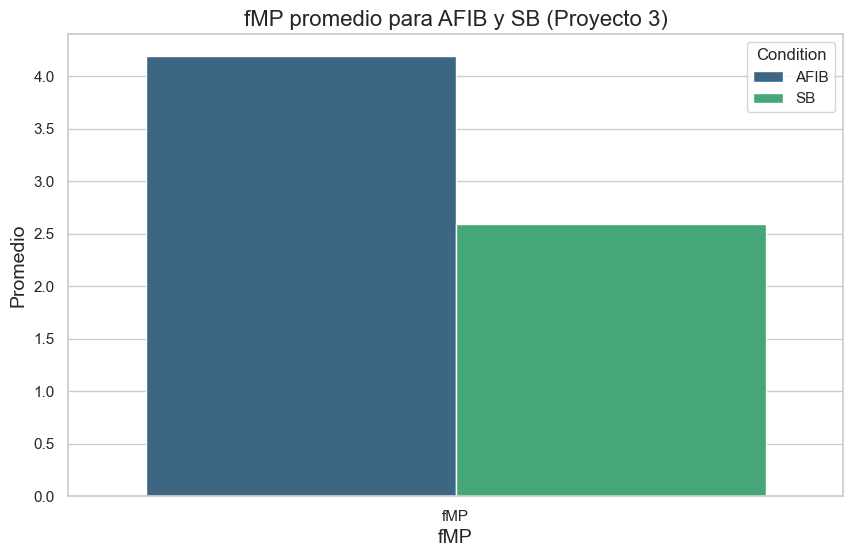

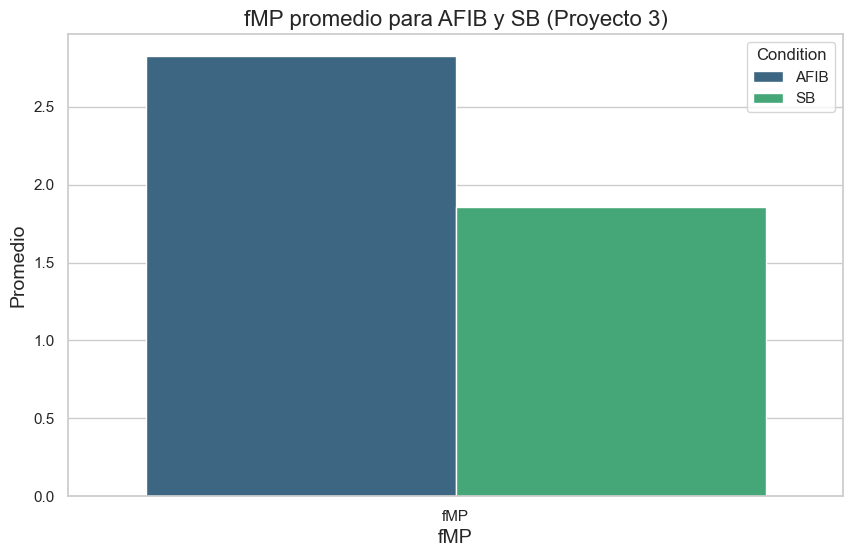

In [133]:
# Calculate mean fMP for AFIB and SB
mean_fMP_AFIB = tabla_general.loc[tabla_general['Estado'] == 'AFIB', 'fMP'].mean()
mean_fMP_SB = tabla_general.loc[tabla_general['Estado'] == 'SB', 'fMP'].mean()

# Create a DataFrame for plotting
mean_values = pd.DataFrame({
    'Metric': ['fMP'],
    'AFIB': [mean_fMP_AFIB],
    'SB': [mean_fMP_SB]
})

# Plot the mean fMP for AFIB and SB
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='value', hue='variable', data=pd.melt(mean_values, id_vars=['Metric']), palette='viridis')
plt.title('fMP promedio para AFIB y SB (Proyecto 3)', fontsize=16)
plt.xlabel('fMP', fontsize=14)
plt.ylabel('Promedio', fontsize=14)
plt.legend(title='Condition')
plt.show()





# Calculate mean fMP for AFIB and SB
mean_fMP_AFIB = df_AFIB['fMP'].mean()
mean_fMP_SB = df_SB['fMP'].mean()

# Create a DataFrame for plotting
mean_values = pd.DataFrame({
    'Metric': ['fMP'],
    'AFIB': [mean_fMP_AFIB],
    'SB': [mean_fMP_SB]
})

# Plot the mean fMP for AFIB and SB
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='value', hue='variable', data=pd.melt(mean_values, id_vars=['Metric']), palette='viridis')
plt.title('fMP promedio para AFIB y SB (Proyecto 3)', fontsize=16)
plt.xlabel('fMP', fontsize=14)
plt.ylabel('Promedio', fontsize=14)
plt.legend(title='Condition')
plt.show()